<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets

In [2]:
# нормализация (применяется к фрейму, а не numpy array)
def normalize(X):
    for i in range(X.shape[1]):
        X = (X - X.mean(axis=0))/X.std(axis=0)   
    return X

In [3]:
# выколупывание классов в удобный вид
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
df = df.drop(np.where(df['target'] == 2)[0])

# разделим руками датафрейм (что-бы все было по хардкору)
# РАЗМЕР тестовой выборки влияет значительно
test_index = np.random.choice (df.index, int (len (df.index)/2), replace = False)
test_df = df.loc [test_index]
train_df = df.loc [~ df.index.isin (test_index)]

train_dX = train_df.drop(df.columns[[4]], axis=1)
train_dy = train_df.drop(df.columns[[0, 1, 2, 3]], axis=1)

test_dX = test_df .drop(df.columns[[4]], axis=1)
test_dy = test_df .drop(df.columns[[0, 1, 2, 3]], axis=1)


train_dX = normalize(train_dX)
# здесь я прилепил дополнительный столбец в фичи, содержащий единицы,  
# что-бы линейная часть имела канонический вид W*X+B. В итоге, как оказалось,
# на точность это влияет в моем случае максимум +/-2%, так что я его закомментил 

# train_dX['free_coef'] = 1 
train_X = train_dX.to_numpy()
train_y = train_dy.to_numpy()

test_dX = normalize(test_dX)
# test_dX['free_coef'] = 1 
test_X = test_dX.to_numpy()
test_y = test_dy.to_numpy()

In [4]:
# определяем начальное приближение 
def init(X):
    return np.random.uniform(0, 1, (X.shape[1], 1))

In [5]:
# определяем сигмоид
def sigmoid(z):
    return 1.0/(1 + np.exp(-z))

In [6]:
# определяем решающую функцию (логистическая регрессия на основе sigmoid)
def H(X, W):
    return sigmoid(X@W)

In [7]:
# функция потерь (кросс-энтропия)
# здесь y_hat = H(X, W)
def loss(y, y_hat):
    return -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))

In [8]:
# градиент кросс-энтропии
def grad(X, y, y_hat):
    return (1/X.shape[0])*(X.T@(y_hat - y))

In [9]:
# градиентный спуск с постоянным шагом без регуляризации
def grad_desc(λ, ε):
    losses = []
    W_0 = init(train_X) # начальные коэффициенты
    W_new = W_0 - λ*grad(train_X, train_y, H(train_X, W_0))
    while abs(max(W_new - W_0)[0])>ε:
        W_0 = W_new
        W_new = W_0 - λ*grad(train_X, train_y, H(train_X, W_0))
        losses.append(loss(train_y, H(train_X, W_new)))
    else:
        return W_new, losses

In [10]:
# предсказатель
def predict(X):
    pred_X = H(X, W_opt)
    pred_class = []
    # пороговое значение ни на что не влияет особо  
    pred_class = [1 if i > 0.8 else 0 for i in pred_X]
    return np.array(pred_class)

In [11]:
# точность
def accuracy(y, y_pred):
    # хитровыделанное преобразование массива тестовых данных
    # к виду, аналогичному выводу предикта
    accuracy = round((np.sum(y.T[0].astype(int) == y_pred) / len(y)),3)
    print(f"Accuracy is {accuracy * 100}%")

**Теперь соберем все в кучу**

In [12]:
λ = 0.001          # статичный шаг 
ε = 0.00001        # погрешность 
W_opt, losses = grad_desc(λ, ε)

In [13]:
W_opt

array([[ 0.8446167 ],
       [-0.95603831],
       [ 1.76927816],
       [ 2.04561977]])

In [14]:
losses[-1]

0.013799066095620694

In [15]:
# глянем на график функции потерь
t = [i for i in range(0, len(losses))]
dictOne = {"t":t, "losses":losses}
df_losses = pd.DataFrame(dictOne)

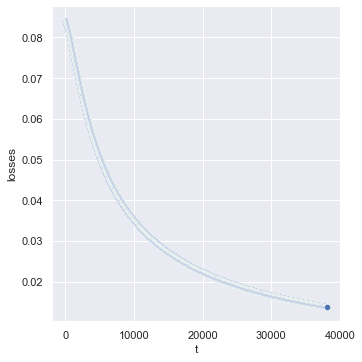

In [16]:
sns.set_theme()
sns.relplot(
    data = df_losses,
    x = "t", y = "losses")

In [17]:
pred_y = predict(test_X)
pred_y

array([0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0])

In [18]:
# not bad)
accuracy(test_y, pred_y)

Accuracy is 100.0%


In [19]:
# определяем начальное приближение иначе
def init_mm(X):
    a = np.min(X)
    b = np.max(X)
    return np.random.uniform(a, b, (X.shape[1], 1))

def grad_desc_mm(λ, ε):
    losses = []
    W_0 = init_mm(train_X) # начальные коэффициенты
    W_new = W_0 - λ*grad(train_X, train_y, H(train_X, W_0))
    while abs(max(W_new - W_0)[0])>ε:
        W_0 = W_new
        W_new = W_0 - λ*grad(train_X, train_y, H(train_X, W_0))
        losses.append(loss(train_y, H(train_X, W_new)))
    else:
        return W_new, losses

In [20]:
λ = 0.001          # статичный шаг
ε = 0.00001        # погрешность
W_opt, losses = grad_desc_mm(λ, ε)
pred_y = predict(test_X)

# офигеть
accuracy(test_y, pred_y)

Accuracy is 96.0%


**Ладно, попробуем методы Momentum и  NAG (по https://towardsdatascience.com/learning-parameters-part-2-a190bef2d12 изложение там мне показалось самым вменяемым)**

In [21]:
def momentum_desc(λ, γ, ε):
    losses = []
    W_0 = init(train_X) # начальные коэффициенты
    Δ_0 = 0
    W_1 = W_0 - Δ_0
    Δ_1 = γ*Δ_0 - λ*grad(train_X, train_y, H(train_X, W_1))
    while abs(max(W_1 - W_0)[0])>ε:
        W_0 = W_1
        Δ_0 = Δ_1
        W_1 = W_0 - Δ_0
        Δ_1 = γ*Δ_0 - λ*grad(train_X, train_y, H(train_X, W_1))
        losses.append(loss(train_y, H(train_X, W_0)))
    else:
        return W_0, losses

In [22]:
γ = 0.9            # момент
λ = 0.001          # статичный шаг
ε = 0.00001        # погрешность
W_opt, losses = momentum_desc(λ, γ, ε)
pred_y = predict(test_X)

# чет не очень
accuracy(test_y, pred_y)

Accuracy is 56.00000000000001%


In [23]:
# Спуск Нестерова
def NAG_desc(λ, γ, ε):
    losses = []
    W_0 = init(train_X) # начальные коэффициенты
    Δ_0 = 0
    W_lh = W_0 - γ*Δ_0  
    Δ_new = γ*Δ_0 + λ*grad(train_X, train_y, H(train_X, W_lh))
    W_new = W_0 - Δ_new
    while abs(max(W_new - W_0)[0])>ε:
        W_0 = W_new
        Δ_0 = Δ_new
        W_lh = W_0 - γ*Δ_0  
        Δ_new = γ*Δ_0 + λ*grad(train_X, train_y, H(train_X, W_lh))
        W_new = W_0 - Δ_new
        losses.append(loss(train_y, H(train_X, W_0)))
    else:
        return W_0, losses

In [24]:
γ = 0.9            # момент
λ = 0.001          # статичный шаг
ε = 0.00001        # погрешность
W_opt, losses = NAG_desc(λ, γ, ε)
pred_y = predict(test_X)

# отлично
accuracy(test_y, pred_y)

Accuracy is 100.0%


**RMSProp (по https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a)**

In [29]:
def RMSProp(λ, γ, ε):
    η = 0.0001
    losses = []
    W_0 = init(train_X) # начальные коэффициенты
    E_0 = 0
    E = γ*E_0 + (1-γ)*(grad(train_X, train_y, H(train_X, W_0)))**2
    W_new = W_0 - (λ/( E**(1/2) + η))*grad(train_X, train_y, H(train_X, W_0))
    while abs(max(W_new - W_0)[0])>ε:
        W_0 = W_new
        E_0 = E
        E = γ*E_0 + (1-γ)*(grad(train_X, train_y, H(train_X, W_0)))**2
        W_new = W_0 - (λ/( E**(1/2) + η))*grad(train_X, train_y, H(train_X, W_0))
    else:
        return W_0, losses

In [30]:
γ = 0.9            # момент
λ = 0.001          # статичный шаг
ε = 0.00001        # погрешность
W_opt, losses = RMSProp(λ, γ, ε)
pred_y = predict(test_X)

# отлично
accuracy(test_y, pred_y)

Accuracy is 100.0%
